In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from scipy import stats  as stat
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Helper functions for model training

In [44]:
def see_data_stored(data_from_customDataFunction):
    x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
    y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
    #z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
    return x,y

#### Data pre-processing for NN 

In [59]:
def data_cleaning_function(dataset):

    """
    Function to clean the lalond dasets.
    
    """
    
    dataset = shuffle(dataset).reset_index(drop=True) # shuffle data 
    dataset.rename(columns={'education*': 'education'}, inplace=True)

    sc = MinMaxScaler()

    # NSW and NSWRE74
    if 'education_17' not in dataset.columns and 'education_18' not in dataset.columns:
        if 're74' in dataset.columns:
            #covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                           #'education_14', 'education_15', 'education_16']  
            covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','re74','re75','education']     
            dataset= dataset[covariate_subset]
            continous_variables = ['ageboxcox','re74','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables
        else:
            #covariate_subset1a = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                           #'education_14', 'education_15', 'education_16']  
            covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','re75','education']     
            dataset= dataset[covariate_subset]
            continous_variables = ['ageboxcox','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables

    #  cps
    if 'education_17' in dataset.columns:

        if 're74' in dataset.columns:
            #covariate_subset1b = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
              #                   'education_14', 'education_15', 'education_16', 'education_17'] 
            covariate_subset1b = ['treat','ageboxcox','black','hispanic','married','nodegree','re74','re75','education']  
            dataset= dataset[covariate_subset1b] 
            continous_variables = ['ageboxcox','re74','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables
        else:
            #covariate_subset1b = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
              #                   'education_14', 'education_15', 'education_16', 'education_17'] 
            covariate_subset1b = ['treat','ageboxcox','black','hispanic','married','nodegree','re75','education']  
            dataset= dataset[covariate_subset1b] 
            continous_variables = ['ageboxcox','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables

    #  Psid 
    if 'education_18' in dataset.columns:
        if 're74' in dataset.columns:
            #covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
            #                      'education_14', 'education_15', 'education_16', 'education_17','education_18'] 
            covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education']
            dataset= dataset[covariate_subset] 
            continous_variables = ['ageboxcox','re74','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables
        else:
            #covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
            #                      'education_14', 'education_15', 'education_16', 'education_17','education_18'] 
            covariate_subset = ['treat','ageboxcox','black','hispanic','married','nodegree','re75','education']                       
            dataset= dataset[covariate_subset] 
            continous_variables = ['ageboxcox','re75'] 
            dataset[continous_variables] = sc.fit_transform(dataset[continous_variables]) # scale continuos variables

    return dataset 


In [60]:
def features_and_targets_function(dataset,upsampling):

    """
    Split dataset into features and targets 
    
    """
    features = dataset.drop('treat', axis=1) # Drop treated units 
    target = dataset.iloc[:,0] # target column
    
    features_as_array = np.array(features)
    target_as_array = np.array(target)

    if upsampling == True:
        resample=SMOTEENN(random_state=0) # resampling
        features_as_array, target_as_array = resample.fit_resample(features_as_array, target_as_array)
    else:
        pass 

    features_as_tensor = torch.tensor(features_as_array)
    target_as_tensor = torch.tensor(target_as_array).unsqueeze(1)
    shape = features_as_tensor.shape[1]

    return features_as_tensor, target_as_tensor,shape; 

In [61]:
from sklearn.model_selection import train_test_split

def train_test_split_upsampled(dataset):

    train_dataset, test_dataset = train_test_split(dataset,  test_size=0.3, random_state=0)

    X_train, y_train,shape_features_train = features_and_targets_function(train_dataset,False)

    X_test, y_test,shape_features_test = features_and_targets_function(train_dataset,True)

    return X_train,y_train,X_test,y_test,shape_features_train;
    

#### Pytorch : custom class for datasets

In [62]:
class CustomDataset:
  def __init__(self,features,target):    
    
    #import features and targets  
    self.features = features              
    self.target = target               
  
  def __len__(self):
    """
    Returns length of the dataset.
    """
    return len(self.features)

  def __getitem__(self,idx):
    """
    Returns features and target with index idx.
    """
    features = self.features[idx]
    target = self.target[idx]    
    return (features, target)

#### construct neural netowrk

### Model 

In [63]:
# Define neural netowork class 
class fourlayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3,num_hidden_4,num_hidden_5):
        super(fourlayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_hidden_4) 
        self.hidden_layer4 =  nn.Linear(num_hidden_4, num_hidden_5)
        self.hidden_layer5 =  nn.Linear(num_hidden_5, num_classes) 
    
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_3)
        self.batchnorm4 = nn.BatchNorm1d(num_hidden_4)
        self.batchnorm5 = nn.BatchNorm1d(num_hidden_5)
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        # second hidden layer 
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        # third hidden layer
        x = self.hidden_layer3(x)
        x = self.relu_activation(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        # fourth hidden layer
        x = self.hidden_layer4(x)
        x = self.relu_activation(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        # fourth out layer
        x = self.hidden_layer5(x)
        x = self.output_activation(x)
        return x


class twoLayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

class ONELayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1):
        super(ONELayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                                               
        self.out_layer =  nn.Linear(num_hidden_1, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()      

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### NN helper functions 

In [64]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__  
    if classname.find('Linear') != -1:
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### Model training - Train, Test Split, no Kfold , with imbalanced dalaloader and upsampling

In [65]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [66]:
def nn_ready_data_function(dataset):
   dataset = data_cleaning_function(dataset)
   X_train,y_train,X_test,y_test,shape =  train_test_split_upsampled(dataset)
   train_data = CustomDataset(features = X_train,target = y_train)
   test_data = CustomDataset(features = X_test,target = y_test)
   return train_data, test_data, shape; 

In [67]:
'''
Load the two datasets.
nsw = Male sub sample of treated and control units as used by Lalonde.
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)
'''
# RCT's 
#nsw = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
#nswre74 = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")

nsw = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv')
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv')

# Quasi data 
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

<P> LOAD SIMULATED DATASET</P>

In [68]:
simulated_dataset = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/simulated_experimental_dataset.csv')
simulated_dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [69]:
import warnings
import sklearn.metrics as metrics
# Functions for ANN training 
# def get loss each epoch 

# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}

train_precision_dict = {}
train_recall_dict = {}
train_f1_dict = {}
train_mse_dict = {}

test_precision_dict = {}
test_recall_dict = {}
test_f1_dict = {}
test_mse_dict = {}

foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}


def store_loss(loss,features,dataloader,running_loss,epoch,dataloader_id):
    if dataloader.__hash__() == dataloader_id:
        
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(dataloader.sampler)
        training_loss_dict[(epoch)] = avg_loss
    else:
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(dataloader.sampler)
        validation_loss_dict[(epoch)] = avg_loss


from sklearn import metrics

# def get metrics 
def store_metrics(pred,target,dataloader,epoch,dataloader_id):
    
    if dataloader.__hash__() == dataloader_id:
        # Precision
        precision = metrics.precision_score(target,pred)
        train_precision_dict[(epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        train_recall_dict[(epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        train_mse_dict[(epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        train_f1_dict[(epoch)] = f1
        warnings.filterwarnings('ignore')
    else:
        precision = metrics.precision_score(target,pred)
        test_precision_dict[(epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        test_recall_dict[(epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        test_mse_dict[(epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        test_f1_dict[(epoch)] = f1
        warnings.filterwarnings('ignore')



In [70]:
# Define train and test
def trainTestModel(train_loader,test_loader,model, optimizer, criterion,params):
    
    model = model
    optimizer = optimizer
    criterion = criterion
    # train & test process
    def train(trainloader,epoch,accuracy,dataloader_id):
        model.train()
        correct = 0
        for data, target in trainloader:
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output
            target = target
            loss = criterion(output, target)
            store_loss(loss,data,trainloader,running_loss,epoch,dataloader_id) # loss for plotting
            pred = (output >= 0.5).type(torch.uint8)
            store_metrics(pred,target,trainloader,epoch,dataloader_id)
            correct += pred.eq(target.view_as(pred)).sum().item()   
            loss.backward()
            optimizer.step()

        train_acc = 100. * correct / len(trainloader.dataset)
        training_accuracy_dict[(epoch)] = train_acc
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting

    def test(testloader,epoch,accuracy,dataloader_id):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.float().to(device), target.float().to(device)
                output = model(data)
                loss = criterion(output , target)
                store_loss(loss,data,test_loader,running_loss,epoch,dataloader_id) # loss for plotting
                pred = (output >= 0.5).type(torch.uint8) 
                #print(pred)
                store_metrics(pred,target,testloader,epoch,dataloader_id)
                correct += pred.eq(target.view_as(pred)).sum().item()
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())
        
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting  
        test_acc = 100. * correct / len(testloader.dataset)
        validation_accuracy_dict[(epoch)] = test_acc
        confusion_mtx = metrics.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []
    trainloader_id = train_loader.__hash__()    
    for epoch in range(1, params[0] + 1):
        running_loss = 0.0
        accuracy = 0
        train(train_loader,epoch,accuracy,trainloader_id)
        test_acc, confusion_mtx = test(test_loader,epoch,accuracy,trainloader_id)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
  

In [71]:
def initialize_model(params,shape): # list of hyper_parameters 
    #model = twoLayerNN(num_features = shape, num_classes  = params[1], num_hidden_1 = params[2],num_hidden_2 = params[3]).to(device)
    model = ONELayerNN(num_features = shape,num_classes = params[1],num_hidden_1 = params[2])
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=params[4],weight_decay=params[5])
    criterion = nn.BCELoss()
    return model, optimizer, criterion

def ANN_RUN(data,params):

    train_data, test_data , shape = nn_ready_data_function(data)

    import sklearn.metrics as metrics
    trainloader = DataLoader(train_data,  batch_size=params[6])
    testloader = DataLoader(test_data,batch_size=params[6])

    # Instanstiate model
    metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    
    model, optimizer, criterion  = initialize_model(params,shape)
    trainTestModel(trainloader,testloader,model, optimizer, criterion,params)

    return model 

In [72]:
train_data, test_data , shape = nn_ready_data_function(nsw)

# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}

train_precision_dict = {}
train_recall_dict = {}
train_f1_dict = {}
train_mse_dict = {}

test_precision_dict = {}
test_recall_dict = {}
test_f1_dict = {}
test_mse_dict = {}

foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}

In [37]:
NUM_HIDDEN_1 = 12
NUM_HIDDEN_2 = 12
NUM_CLASSES = 1
NUM_EPOCHS = 50
BATCH_SIZE = 1000
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.018

params = [NUM_EPOCHS,NUM_CLASSES,NUM_HIDDEN_1,NUM_HIDDEN_2,LEARNING_RATE,WEIGHT_DECAY,BATCH_SIZE]

In [38]:
model1 = ANN_RUN(nswCps_lalonde,params)
#model2 = ANN_RUN(nswCps_lalonde,params)
#model3 = ANN_RUN(nswCps_dehWab,params)
#model4 = ANN_RUN(nswPsid_dehWab,params)

Best test acc = 81.44%

In [39]:
# Create lists
train_accuracy_list = list(training_accuracy_dict.values())
test_accuracy_list = list(validation_accuracy_dict.values())

train_loss_list = list(training_loss_dict.values())
test_loss_list = list(validation_loss_dict.values())

train_precision_list = list(train_precision_dict.values()) 
train_recall_list = list(train_recall_dict.values()) 

train_f1_list = list(train_f1_dict.values())
train_mse_list = list(train_mse_dict.values())

test_precision_list = list(test_precision_dict.values()) 
test_recall_list = list(test_recall_dict.values()) 
test_f1_list = list(test_f1_dict.values())
test_mse_list = list(test_mse_dict.values())

In [40]:
print(f'avg train acc: {np.mean(train_accuracy_list):.2f} | 'f'avg test acc : {np.mean(test_accuracy_list):.2f} | '
      f'avg train prec : {np.mean(train_precision_list):.2f} |'f'avg test prec : {np.mean(test_precision_list):.2f} |'
      f' avg train mse: {np.mean(train_mse_list):.2f} | ' f'avg test mse: {np.mean(test_mse_list):.2f} |'
      f' avg train F1: {np.mean(train_f1_list):.2f} | 'f' avg test F1: {np.mean(test_f1_list):.2f}')

avg train acc: 64.43 | avg test acc : 53.23 | avg train prec : 0.03 |avg test prec : 1.00 | avg train mse: 0.37 | avg test mse: 0.64 | avg train F1: 0.05 |  avg test F1: 0.47


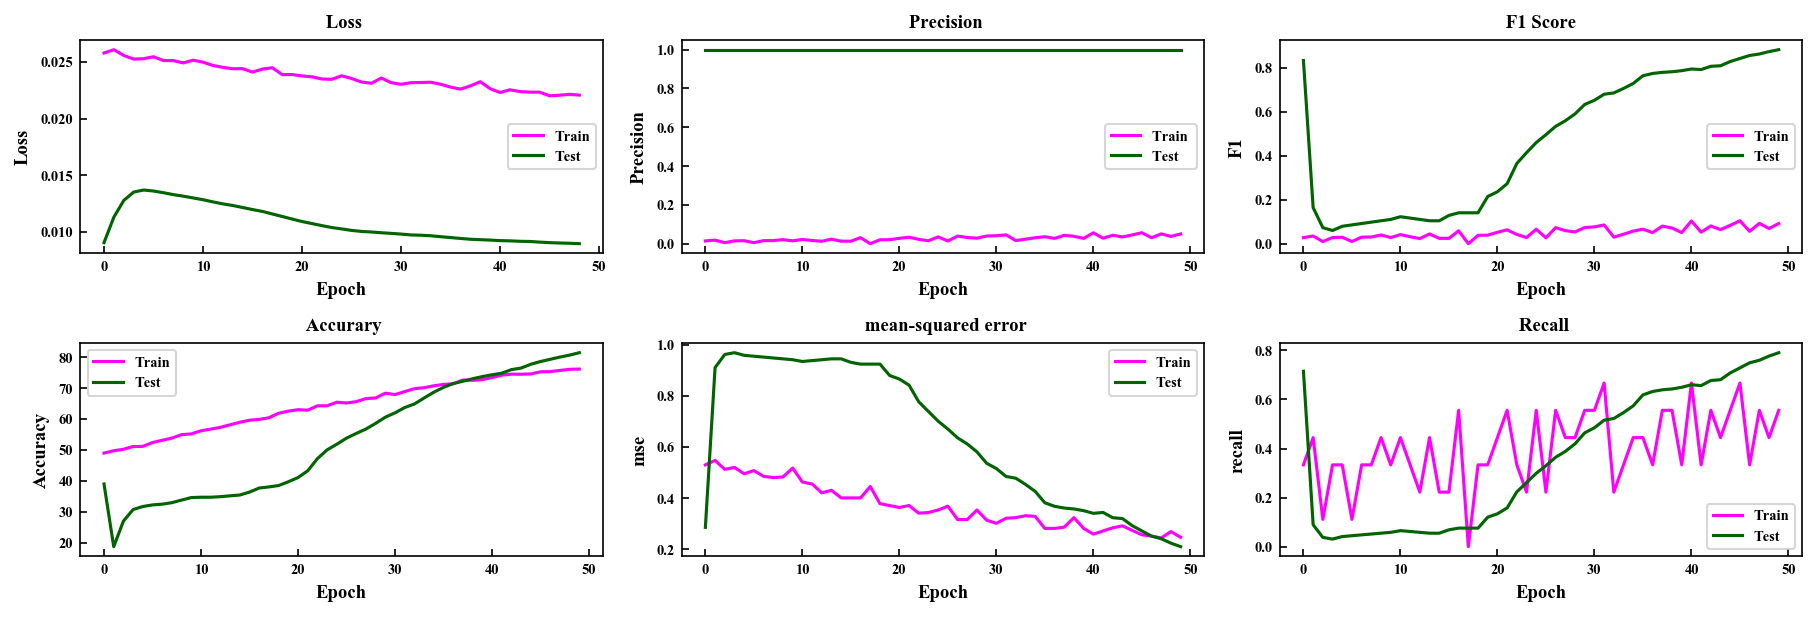

In [41]:
from tueplots import axes, bundles , figsizes, fonts,fontsizes
# Create plots of all metrics 

# Global plot settings 

fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,4))
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())


#x-axis
xrange = range(0,NUM_EPOCHS+1)

# Loss
ax[0,0].plot(range(0,len(train_loss_list)-1), train_loss_list[:-1], label='Train',color='magenta')
ax[0,0].plot(range(0,len(test_loss_list)-1), test_loss_list[:-1], label='Test',color = 'darkgreen')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title(' Loss')

# Precison 
ax[0,1].plot(range(0,len(train_precision_list)), train_precision_list, label='Train ',color='magenta')
ax[0,1].plot(range(0,len(test_precision_list)), test_precision_list, label='Test ',color = 'darkgreen')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Precision')
ax[0,1].set_title(' Loss')
ax[0,1].set_title(' Precision')
ax[0,1].legend()
# F1 
ax[0,2].plot(range(0,len(train_f1_list)), train_f1_list, label='Train',color='magenta')
ax[0,2].plot(range(0,len(test_f1_list)), test_f1_list, label='Test',color = 'darkgreen')
ax[0,2].set_xlabel('Epoch')
ax[0,2].set_ylabel('F1')
ax[0,2].set_title(' Loss')
ax[0,2].set_title(' F1 Score ')
ax[0,2].legend()
# Accuracy 
ax[1,0].plot(range(0,len(train_accuracy_list)), train_accuracy_list, label='Train',color='magenta')
ax[1,0].plot(range(0,len(test_accuracy_list)), test_accuracy_list, label='Test',color = 'darkgreen')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_title(' Accurary')
ax[1,0].legend()
# MSE
ax[1,1].plot(range(0,len(train_mse_list)), train_mse_list, label='Train',color='magenta')
ax[1,1].plot(range(0,len(test_mse_list)), test_mse_list, label='Test',color = 'darkgreen')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('mse')
ax[1,1].set_title(' mean-squared error')
ax[1,1].legend()
# recall
ax[1,2].plot(range(0,len(train_recall_list)), train_recall_list, label='Train',color='magenta')
ax[1,2].plot(range(0,len(test_recall_list)), test_recall_list, label='Test',color = 'darkgreen')
ax[1,2].set_xlabel('Epoch')
ax[1,2].set_ylabel('recall')
ax[1,2].set_title(' Recall')
ax[1,2].legend()

In [42]:
def predict_function(dataset,model):

    """
    Split dataset into features and targets 
    
    """
    
    dataset_preclean = dataset
    dataset = data_cleaning_function(dataset)
    
    features = dataset.drop('treat', axis=1) # drop treatment column 
    target = dataset.iloc[:,0] # target column
    features_as_array = np.array(features)
    target_as_array = np.array(target)

    features_as_tensor = torch.tensor(features_as_array)
    features_as_tensor= features_as_tensor.to(torch.float)


    with torch.no_grad():
        prediction =  model(features_as_tensor)
   
    prediction_array = prediction.numpy() 
    prediction_df = pd.DataFrame(prediction_array)
    dataset_proba = pd.merge(dataset_preclean, prediction_df, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))

    return dataset_proba

In [43]:
nswlalonde_ps_ANN = predict_function(nswCps_lalonde,model1)

In [44]:
nswlalonde_ps_ANN

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18,propensity_score,propensity_logit
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,1,0,0,0,0,0,0,0,0.549435,0.198387
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,0,0,0,0,0,0,0,0,0.502992,0.011970
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,1,0,0,0,0,0,0,0.460057,-0.160113
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,1,0,0,0,0,0,0,0,0.449427,-0.202987
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,0,0,0,0,0,0,0,0,0.462181,-0.151566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16284,0.0,22,1.0,0.0,0.0,0.0,6801,2757,12,0,...,0,1,0,0,0,0,0,0,0.421178,-0.317938
16285,0.0,20,1.0,0.0,1.0,0.0,11832,6895,12,0,...,0,1,0,0,0,0,0,0,0.362444,-0.564772
16286,0.0,37,0.0,0.0,0.0,0.0,1559,4221,12,0,...,0,1,0,0,0,0,0,0,0.462562,-0.150034
16287,0.0,47,0.0,0.0,1.0,1.0,11384,13671,9,0,...,0,0,0,0,0,0,0,0,0.466882,-0.132667


In [129]:
# save unmatched boost datasets 
#nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN.csv')
#nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN.csv')
#nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN.csv')
#nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN.csv')

# K-Fold cross validation

In [130]:
# Functions for ANN training 
# def get loss each epoch 

from sklearn import metrics

def store_loss_kf(loss,features,dataloader,running_loss,epoch,dataloader_id,fold):
    if dataloader.__hash__() == dataloader_id:
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(dataloader.sampler)
        training_loss_dict[(fold,epoch)] = avg_loss
    else:
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(dataloader.sampler)
        validation_loss_dict[(fold,epoch)] = avg_loss

# def get metrics 
def store_metrics_kf(pred,pred_prob,target,dataloader,epoch,dataloader_id,logging_df,fold):
    
    if dataloader.__hash__() == dataloader_id:
        # Precision
        precision = metrics.precision_score(target,pred)
        train_precision_dict[(fold,epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        train_recall_dict[(fold,epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        train_mse_dict[(fold,epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        train_f1_dict[(fold,epoch)] = f1
        warnings.filterwarnings('ignore')

        logging_df.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(target, pred)
        logging_df.loc['Precision:', fold] = metrics.precision_score(target, pred)
        logging_df.loc['Recall:', fold] = metrics.recall_score(target, pred)
        logging_df.loc['MSE:', fold] =  metrics.mean_squared_error(target, pred)
        logging_df.loc['MAE:', fold] =  metrics.mean_absolute_error(target, pred)
        logging_df.loc['R^2:', fold] =  metrics.r2_score(target, pred)
        #logging_df.loc['auc:', fold] =  metrics.roc_auc_score(target, pred)
        #logging_df.loc['roc_auc:', fold] =  metrics.roc_auc_score(target, pred_prob)
        #logging_df.loc['roc_auc:', fold] =  metrics.roc_auc_score(target, pred)
        logging_df.loc['F1:', fold] =  metrics.f1_score(target, pred)
        #logging_df.loc['log-loss:', fold] = metrics.log_loss(target, pred_prob)


    else:
        precision = metrics.precision_score(target,pred)
        test_precision_dict[(fold,epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        test_recall_dict[(fold,epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        test_mse_dict[(fold,epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        test_f1_dict[(fold,epoch)] = f1
        warnings.filterwarnings('ignore')

        logging_df.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(target, pred)
        logging_df.loc['Precision:', fold] = metrics.precision_score(target, pred)
        logging_df.loc['Recall:', fold] = metrics.recall_score(target, pred)
        logging_df.loc['MSE:', fold] =  metrics.mean_squared_error(target, pred)
        logging_df.loc['MAE:', fold] =  metrics.mean_absolute_error(target, pred)
        logging_df.loc['R^2:', fold] =  metrics.r2_score(target, pred)
        #logging_df.loc['auc:', fold] =  metrics.roc_auc_score(target, pred)
        # logging_df.loc['roc_auc:', fold] =  metrics.roc_auc_score(target, pred_prob)
        logging_df.loc['F1:', fold] =  metrics.f1_score(target, pred)
        #logging_df.loc['log-loss:', fold] = metrics.log_loss(target, pred_prob)



In [131]:
# Define train and test for KFold 
def trainTestModelKfold(train_loader, test_loader,hyper_param_list,metrics_df,fold,shape):
    
    model, optimizer, criterion  = initialize_model(hyper_param_list,shape)

    # train & test process
    def train(trainloader,epoch,accuracy,dataloader_id):
        model.train()
        correct = 0
        for data, target in trainloader:
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
           # output = output
           # target = target
            loss = criterion(output, target)
            store_loss_kf(loss,data,trainloader,running_loss,epoch,dataloader_id,fold) # loss for plotting
            pred = (output >= 0.5).type(torch.uint8)
            pred_prob = output.detach().numpy()
            store_metrics_kf(pred,pred_prob,target,trainloader,epoch,dataloader_id,metrics_df,fold)
            correct += pred.eq(target.view_as(pred)).sum().item()   
            loss.backward()
            optimizer.step()

        train_acc = 100. * correct / len(trainloader.dataset)
        training_accuracy_dict[(epoch)] = train_acc
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting

    def test(testloader,epoch,accuracy,dataloader_id):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.float().to(device), target.float().to(device)
                output = model(data)
                loss = criterion(output , target)
                store_loss_kf(loss,data,test_loader,running_loss,epoch,dataloader_id,fold) # loss for plotting
                pred = (output >= 0.5).type(torch.uint8) 
                pred_prob = output.detach().numpy()
                store_metrics_kf(pred,pred_prob,target,testloader,epoch,dataloader_id,metrics_df,fold)
                correct += pred.eq(target.view_as(pred)).sum().item()
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())
        
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting  
        test_acc = 100. * correct / len(testloader.dataset)
        validation_accuracy_dict[(epoch)] = test_acc
        confusion_mtx = metrics.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []
    trainloader_id = train_loader.__hash__()    
    for epoch in range(1, NUM_EPOCHS + 1):
        running_loss = 0.0
        accuracy = 0
        train(train_loader,epoch,accuracy,trainloader_id)
        test_acc, confusion_mtx = test(test_loader,epoch,accuracy,trainloader_id)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        

  

In [132]:
def setup_dataflow(data,train_idx,val_idx,batch_size_train,batch_size_test):

    def features_and_targets_function2(dataset,upsampling):
        features = dataset.drop('treat', axis=1) # Drop treated units 
        target = dataset.iloc[:,0] # target column
        features_as_array = np.array(features)
        target_as_array = np.array(target)

        if upsampling == True:
            resample=SMOTEENN(random_state=0) # resampling
            features_as_array, target_as_array = resample.fit_resample(features_as_array, target_as_array)
        else:
            pass 

        features_as_tensor = torch.tensor(features_as_array)
        target_as_tensor = torch.tensor(target_as_array).unsqueeze(1)
        shape = features_as_tensor.shape[1]
        return features_as_tensor, target_as_tensor,shape; 

    #def upsample_training_data(dataset,train_idx):
    #    dataset_training = dataset.loc[train_idx,] 
    #    cols = dataset_training.columns.tolist()
    #    features = dataset_training.drop('treat', axis=1) # Drop treated units 
    #    target = dataset_training.iloc[:,0] # target column
    #    resample=SMOTEENN(random_state=0) # resampling
    #    features, target = resample.fit_resample(features, target)
    #    dataset_training_upsampled = pd.concat([target,features],axis=1,ignore_index=False,join="inner")
    #    dataset_training_upsampled = dataset_training_upsampled[cols]
    #    dataset_training_upsampled = dataset_training_upsampled.sample(frac=1,random_state=0)
    #    return dataset_training_upsampled;    

    dataset_no_augmentation = data
    dataset_augmented_training =  data.iloc[train_idx,]
    upsampled_train_index = np.array(data.index)
    
    train_sampler = SubsetRandomSampler(upsampled_train_index)
    val_sampler = SubsetRandomSampler(val_idx)

    features_train, target_train , shape2 = features_and_targets_function2(dataset_augmented_training,True) # training 
    features_test, target_test , shape1 = features_and_targets_function2(dataset_no_augmentation,False) # testing 
    
    train_data = CustomDataset(features = features_train,target = target_train)
    test_data = CustomDataset(features = features_test,target = target_test)

    train_loader = DataLoader(train_data, batch_size=batch_size_train, sampler=train_sampler)
    val_loader = DataLoader(test_data, batch_size=batch_size_test, sampler=val_sampler)

    return train_loader, val_loader,shape2;

In [133]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
def ANN_KFOLD(dataset,hyper_param_list,metrics_df):

    def features_and_targets_function_skf(dataset):
        features = dataset.drop('treat', axis=1) # Drop treated units 
        target = dataset.iloc[:,0] # target column
        features_as_array = np.array(features)
        target_as_array = np.array(target)
        shape = features_as_array.shape[1]
        return features_as_array, target_as_array,shape; 

    
    data_clean = data_cleaning_function(dataset) # clean dataset, contains training and testing samples 
    features_no_split, target_no_split ,shape =  features_and_targets_function_skf(data_clean) # create features and targets for kfold to index them
    
    data_idx = np.arange(len(data_clean))
    skfold = KFold(n_splits=5, random_state=None, shuffle=False) # create stratified kfold object

    for fold_idx, (train_idx,val_idx) in enumerate(skfold.split(features_no_split,target_no_split)):
    #for fold_idx, (train_idx,val_idx) in enumerate(skfold.split(data_idx)):
        
        print('Fold {}'.format(fold_idx + 1))
        trainloader, testloader,shape = setup_dataflow(data_clean, train_idx, val_idx,hyper_param_list[6],hyper_param_list[7])
        trainTestModelKfold(trainloader,testloader,hyper_param_list,metrics_df,fold_idx,shape)
    

In [134]:
x = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))

def features_and_targets_function_skf(dataset):
        features = dataset.drop('treat', axis=1) # Drop treated units 
        target = dataset.iloc[:,0] # target column
        features_as_array = np.array(features)
        target_as_array = np.array(target)
        shape = features_as_array.shape[1]
        return features_as_array, target_as_array; 

x,y  = features_and_targets_function_skf(x)

In [160]:
NUM_FEATURES = 7
NUM_HIDDEN_1 = 100
NUM_HIDDEN_2 = 50
NUM_CLASSES = 1
NUM_EPOCHS = 50
batch_size_train = 64
batch_size_test =  64
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.018


params = [NUM_FEATURES,NUM_CLASSES,NUM_HIDDEN_1,NUM_HIDDEN_2,LEARNING_RATE,WEIGHT_DECAY,batch_size_train,batch_size_test]



In [161]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}

train_precision_dict = {}
train_recall_dict = {}
train_f1_dict = {}
train_mse_dict = {}

test_precision_dict = {}
test_recall_dict = {}
test_f1_dict = {}
test_mse_dict = {}


foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}

In [162]:
ann_metrics = pd.DataFrame()
ANN_KFOLD(nswCps_lalonde,params,ann_metrics)

Fold 1
Best test acc = 19.19%Fold 2
Best test acc = 19.40%Fold 3
Best test acc = 19.30%Fold 4
Best test acc = 19.38%Fold 5
Best test acc = 19.31%

In [163]:
# Create lists
train_accuracy_list = list(training_accuracy_dict.values())
test_accuracy_list = list(validation_accuracy_dict.values())

train_loss_list = list(training_loss_dict.values())
test_loss_list = list(validation_loss_dict.values())

train_precision_list = list(train_precision_dict.values()) 
train_recall_list = list(train_recall_dict.values()) 

train_f1_list = list(train_f1_dict.values())
train_mse_list = list(train_mse_dict.values())

test_precision_list = list(test_precision_dict.values()) 
test_recall_list = list(test_recall_dict.values()) 
test_f1_list = list(test_f1_dict.values())
test_mse_list = list(test_mse_dict.values())

In [164]:
print(f'avg train acc: {np.mean(train_accuracy_list):.2f} | 'f'avg test acc : {np.mean(test_accuracy_list):.2f} | '
      f'avg train prec : {np.mean(train_precision_list):.2f} |'f'avg test prec : {np.mean(test_precision_list):.2f} |'
      f' avg train mse: {np.mean(train_mse_list):.2f} | ' f'avg test mse: {np.mean(test_mse_list):.2f} |'
      f' avg train F1: {np.mean(train_f1_list):.2f} | 'f' avg test F1: {np.mean(test_f1_list):.2f}')

avg train acc: 63.49 | avg test acc : 19.04 | avg train prec : 0.92 |avg test prec : 0.25 | avg train mse: 0.05 | avg test mse: 0.05 | avg train F1: 0.89 |  avg test F1: 0.33


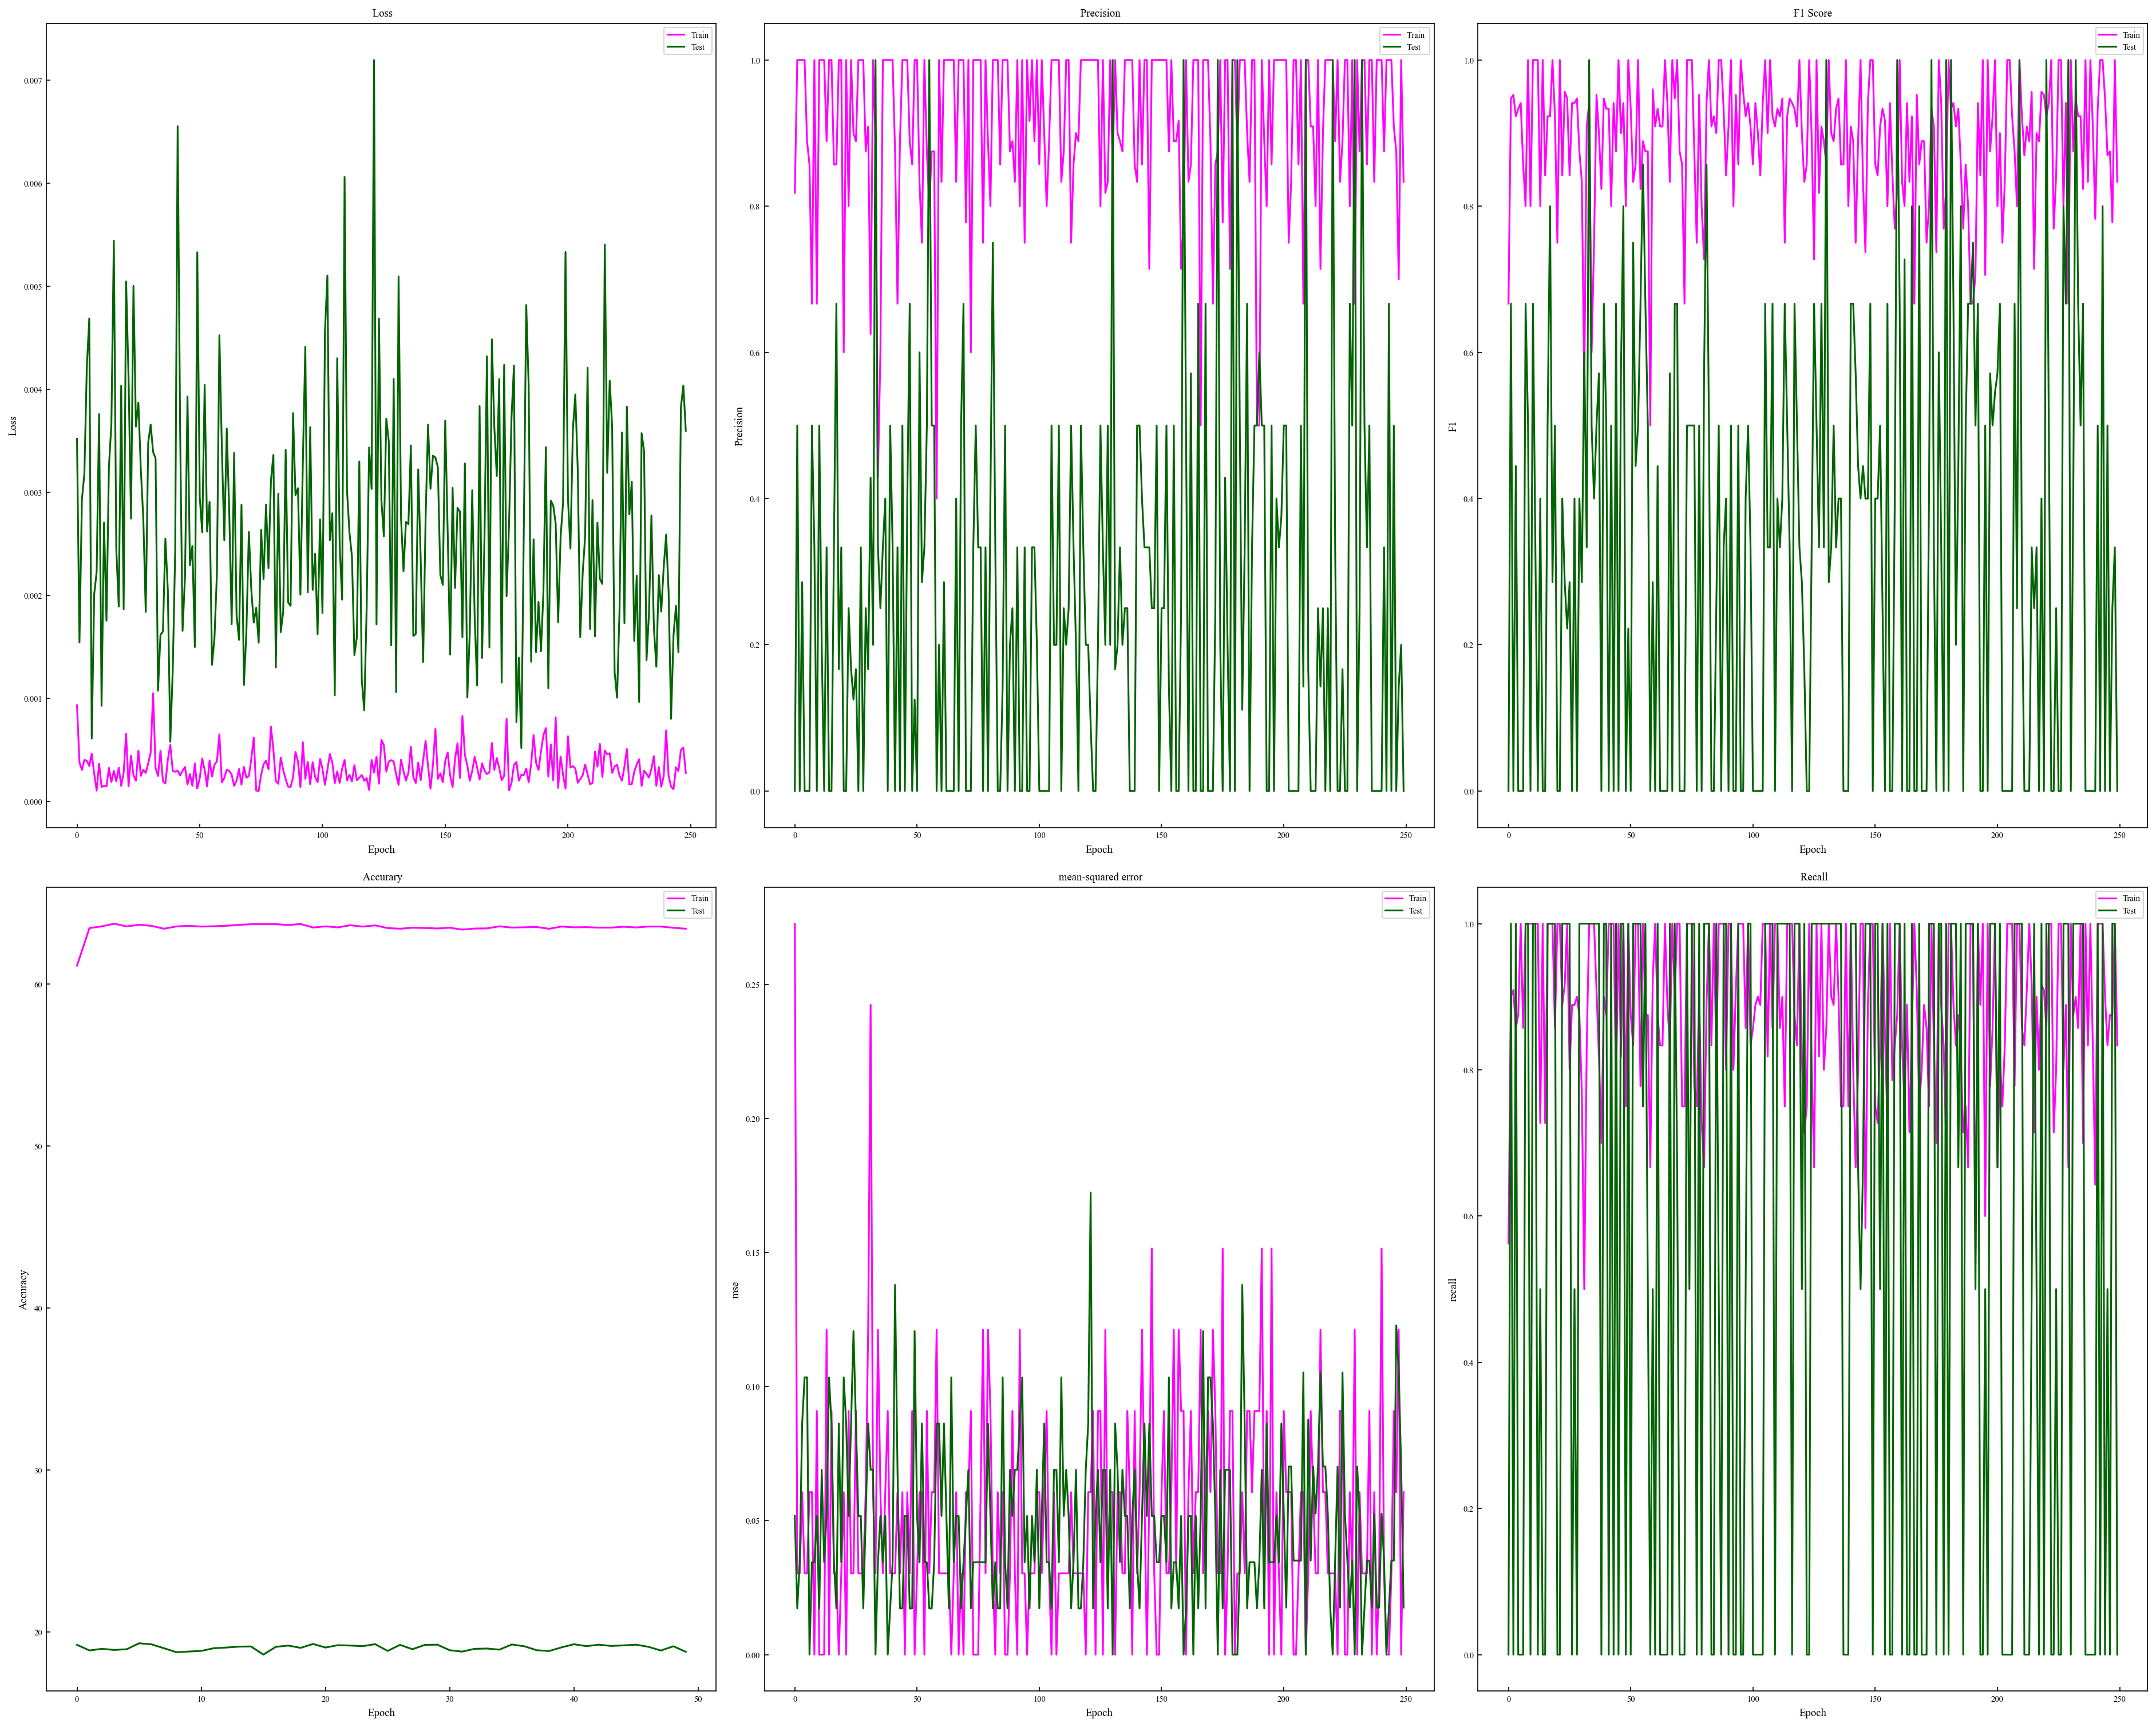

In [165]:
from tueplots import axes, bundles , figsizes, fonts,fontsizes
# Create plots of all metrics 

# Global plot settings 

fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,20))
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())


#x-axis
xrange = range(0,NUM_EPOCHS+1)

# Loss
ax[0,0].plot(range(0,len(train_loss_list)-1), train_loss_list[:-1], label='Train',color='magenta')
ax[0,0].plot(range(0,len(test_loss_list)-1), test_loss_list[:-1], label='Test',color = 'darkgreen')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title(' Loss')

# Precison 
ax[0,1].plot(range(0,len(train_precision_list)), train_precision_list, label='Train ',color='magenta')
ax[0,1].plot(range(0,len(test_precision_list)), test_precision_list, label='Test ',color = 'darkgreen')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Precision')
ax[0,1].set_title(' Loss')
ax[0,1].set_title(' Precision')
ax[0,1].legend()
# F1 
ax[0,2].plot(range(0,len(train_f1_list)), train_f1_list, label='Train',color='magenta')
ax[0,2].plot(range(0,len(test_f1_list)), test_f1_list, label='Test',color = 'darkgreen')
ax[0,2].set_xlabel('Epoch')
ax[0,2].set_ylabel('F1')
ax[0,2].set_title(' Loss')
ax[0,2].set_title(' F1 Score ')
ax[0,2].legend()
# Accuracy 
ax[1,0].plot(range(0,len(train_accuracy_list)), train_accuracy_list, label='Train',color='magenta')
ax[1,0].plot(range(0,len(test_accuracy_list)), test_accuracy_list, label='Test',color = 'darkgreen')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_title(' Accurary')
ax[1,0].legend()
# MSE
ax[1,1].plot(range(0,len(train_mse_list)), train_mse_list, label='Train',color='magenta')
ax[1,1].plot(range(0,len(test_mse_list)), test_mse_list, label='Test',color = 'darkgreen')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('mse')
ax[1,1].set_title(' mean-squared error')
ax[1,1].legend()
# recall
ax[1,2].plot(range(0,len(train_recall_list)), train_recall_list, label='Train',color='magenta')
ax[1,2].plot(range(0,len(test_recall_list)), test_recall_list, label='Test',color = 'darkgreen')
ax[1,2].set_xlabel('Epoch')
ax[1,2].set_ylabel('recall')
ax[1,2].set_title(' Recall')
ax[1,2].legend()